In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
# !pwd

In [5]:
df = pd.read_csv("/Users/bhavi/Documents/Projects/CristianoRonaldo/Cristano_Ronaldo_Final_v1/data.csv")

In [6]:
df = df.rename(columns={'lat/lng':'lat_lng',\
                        'distance_of_shot.1': 'distance_of_shot_1', \
                        'remaining_min.1':'remaining_min_1', \
                        'power_of_shot.1':'power_of_shot_1', \
                        'knockout_match.1' : 'knockout_match_1', \
                        'remaining_sec.1' : 'remaining_sec_1'})


print (df[df.match_id.isnull()].shape) # match_id is never null


# for col in df.columns:
#     print (f"'{col}'", end=',')

(0, 28)


In [ ]:
df.describe()

In [ ]:
df.corr()

In [ ]:
# pd.scatter_matrix(df[['match_event_id','remaining_min','remaining_sec', 'remaining_min_1', 'remaining_sec_1', 'distance_of_shot_1']], alpha=0.6, figsize=(10, 10), diagonal='kde')
# plt.show()

In [7]:
'''
    Filling Missing Values of game_season by padding on previous values
'''

print(df[df.game_season.isnull()].shape)
df['game_season'] = df['game_season'].fillna(method='pad')

df['game_season'] = df['game_season'].apply(
    lambda x: x.split('-')[0]
)

# print(df[df.game_season.isnull()].shape)


(5862, 28)


In [8]:
'''
    Filling Missing Values of date_of_game by padding on previous values
'''

print(df[df.date_of_game.isnull()].shape)
df['date_of_game'] = df['date_of_game'].fillna(method='pad')

print(df[df.date_of_game.isnull()].shape)

'''
    Generating new features for day month and year
'''

df['day'] = df['date_of_game'].apply(
    lambda x: x.split('-')[0]
)

df['month'] = df['date_of_game'].apply(
    lambda x: x.split('-')[1]
)

df['year'] = df['date_of_game'].apply(
    lambda x: x.split('-')[2]
)

(1550, 28)
(0, 28)


In [9]:
'''
    Filling Missing Values of lat_lng by padding on previous values
'''

print(df[df.lat_lng.isnull()].shape)
df['lat_lng'] = df['lat_lng'].fillna(method='pad')

print(df[df.lat_lng.isnull()].shape)

'''
    lat_lng is categorical based on arena of match - we can label encode it
'''
print(df.lat_lng.unique().shape)
df['lat_lng'] = df['lat_lng'].astype('category').cat.codes

(1565, 31)
(0, 31)
(38,)


In [10]:
# Match Event Id

# for i in range(2, len(df[df.match_event_id.isnull()])):
#     df.loc[i, 'match_event_id'] = df.loc[i-1, 'match_event_id']

'''
    Fill Missing Match Event Id By Looking at Row Above And Below with same Game Id,
    pass in case of any error.
'''
for index, row in df[df.match_event_id.isnull()].iterrows():
    try:
        if df.loc[index - 1, 'match_id'] == row['match_id']:
            df.loc[index, 'match_event_id'] = int(df.loc[index-1, 'match_event_id']) + 1
        elif df.loc[index + 1, 'match_id'] == row['match_id']:
            df.loc[index, 'match_event_id'] = int(df.loc[index+1, 'match_event_id']) + 1
        else:
            df.loc[index, 'match_event_id'] = int(df.loc[index-1, 'match_event_id']) + 1
    except:
        pass

'''
    Fill Remaining Rows(only 10) with mode value
'''
df['match_event_id'] = df['match_event_id'].fillna(method='pad')
# df['match_event_id'].fillna(df['match_event_id'].mode()[0], inplace=True)

In [11]:
'''
    Filling Missing Valued For Knockout Matches
'''
def fillKnockoutMatches(row):
    if row.name >= 26198:
        return 1
    else:
        return 0
    
df['knockout_match'] = df['knockout_match'].fillna(method='pad')

In [12]:
'''
    Filling some Distance Of Shot Feature values based on another feature by the same name.
    Second feature has noise in form of decimal numbers, so making sure that is not used
'''

df['distance_of_shot'] = df.apply(
    lambda row: row['distance_of_shot_1'] if np.isnan(row['distance_of_shot']) and (row['distance_of_shot_1']).is_integer() else row['distance_of_shot'],
    axis=1
)
# Filling remaing missing distance values with mean
df['distance_of_shot'].fillna(df['distance_of_shot'].mean(), inplace=True)


df['remaining_min'] = df.apply(
    lambda row: row['remaining_min_1'] if np.isnan(row['remaining_min']) and (row['remaining_min_1']).is_integer() else row['remaining_min'],
    axis=1
)
'''
    Time Remaining has no significant correlation with any of the features. Replacing missing 
    values of it by mean value of feature
'''
df['remaining_min'].fillna(df['remaining_min'].mean(), inplace=True)

In [13]:
'''
    Preprocessing area field to contain only area abbreviation
'''
def findArea(x):
    if type(x) == float and np.isnan(x):
        return x
    else:
        return x.split('(')[1].split(')')[0]

df["area_of_shot"] = df["area_of_shot"].apply(findArea)

'''
    Label encoding area of shot. It encodes NaN value as -1. This will be handled as a different category when we One Hot Encode this while training.
'''

# print(df['area_of_shot'])
df['area_of_shot'].fillna("Unique", inplace=True) #Replacing NaN values with a unique value(quite literally)
df['area_of_shot'] = df['area_of_shot'].astype('category').cat.codes
# print(df['area_of_shot'])

In [14]:
'''
    Preprocessing Range of Shot to give lower and upper range
'''
def processRangeOfShot(row):
    range_of_shot = str(row['range_of_shot'])
    try:
        if "Less Than" in range_of_shot:
            return 0, 8
        elif "+" in range_of_shot:
            return 24, 32
        else:
            low = range_of_shot.split('-')[0]
            high = range_of_shot.split('-')[1][0:2]
            return low, high
    except Exception as e:
        return float('NaN'), float('NaN')
    
df['lower_range'], df['upper_range'] = zip(*df.apply(processRangeOfShot, axis=1))

'''
    Filling Remaining values with mode of feature
'''

df['lower_range'].fillna(df['lower_range'].mode()[0], inplace=True)
df['upper_range'].fillna(df['upper_range'].mode()[0], inplace=True)

In [15]:
''' 
    Processing Home/away
'''
def processHome(row):
    val = row['home/away']
    try:
        if '@' in val:
            return 0
        elif 'vs' in val:
            return 1
    except:
        return val
    
df['home'] = df.apply(processHome, axis=1)

'''
    Filling Missing Values
'''
df['home'] = df['home'].fillna(method='pad')

In [16]:
'''
    One of 'type_of_shot' and 'type_of_combined_shot' is always present in data
'''

print(df[df.type_of_shot.isnull() & df.type_of_combined_shot.isnull()].shape)

'''
    Label encoding type_of_shot and type_of_combined_shot. It encodes NaN value as -1. This will be handled when we One Hot Encode this while training.
'''
df['type_of_shot'].fillna("Unique", inplace=True) #Replacing NaN values with a unique value(quite literally)
df['type_of_shot'] = df['type_of_shot'].astype('category').cat.codes

df['type_of_combined_shot'].fillna("Unique", inplace=True) #Replacing NaN values with a unique value(quite literally)
df['type_of_combined_shot'] = df['type_of_combined_shot'].astype('category').cat.codes


(0, 34)


In [17]:
'''
    Filling Missing data with mode and then label encoding
'''

df['shot_basics'].fillna(df['shot_basics'].mode()[0], inplace=True)
df['shot_basics'] = df['shot_basics'].astype('category').cat.codes

In [ ]:
for col in df.columns:
    print (f"'{col}'", end=',')

In [18]:
'''
    Finding Missing Values Of power_of_shot which has high correlation with match_event_id by a logistic regression model
'''
def logisticRegressionForPowerOfShot(data):    
    from sklearn.linear_model import LogisticRegression
    linreg = LogisticRegression()

    sub = data[data.power_of_shot.notnull()]
    sub = sub[sub.match_event_id.notnull()]
    X_train = sub[['match_event_id']]
    y_train = sub[['power_of_shot']]

    sub = data[data.power_of_shot.isnull()]
    sub = sub[sub.match_event_id.notnull()]
    X_test = sub[['match_event_id']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.power_of_shot.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.power_of_shot.notnull()]['power_of_shot'].mean())

    data.loc[data.power_of_shot.isnull() & data.match_event_id.notnull() , 'power_of_shot'] = predicted 
    
    return data

df = logisticRegressionForPowerOfShot(df.copy())

# df = df.drop(df[df.location_x.isnull()].index)

df['power_of_shot'].fillna(df['power_of_shot'].mode()[0], inplace=True)

(1486, 34) (1486,)
2.588829071332436 2.51935914552737


/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
df[['location_x', 'location_y', 'distance_of_shot']].corr()

In [19]:
'''
    Finding Missing Values Of Location_x by a linear regression model
'''
def linearRegressionForLocation_X(data):    
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()

    sub = data[data.location_x.notnull()]
    sub = sub[sub.location_y.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_train = sub[['location_y', 'distance_of_shot', 'lower_range', 'upper_range']]
    y_train = sub[['location_x']]

    sub = data[data.location_x.isnull()]
    sub = sub[sub.location_y.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_test = sub[['location_y', 'distance_of_shot', 'lower_range', 'upper_range']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.location_x.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.location_x.notnull()]['location_x'].mean())

    data.loc[data.location_x.isnull() & \
             data.location_y.notnull() & \
            data.distance_of_shot.notnull() & \
            data.lower_range.notnull() & \
            data.upper_range.notnull(), 'location_x'] = predicted 
    
    return data

df = linearRegressionForLocation_X(df.copy())

# df = df.drop(df[df.location_x.isnull()].index)

df['location_x'].fillna(df['location_x'].mean(), inplace=True)


(1461, 34) (1383, 1)
7.225532136850007 7.383876043234369


/Users/bhavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/bhavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
'''
    Finding Missing Values Of Location_y by a linear regression model
'''
def linearRegressionForLocation_Y(data):
    from sklearn.linear_model import LinearRegression

    linreg = LinearRegression()

    sub = data[data.location_y.notnull()]
    sub = sub[sub.location_x.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_train = sub[['location_x', 'distance_of_shot', 'lower_range', 'upper_range']]
    y_train = sub[['location_y']]

    print (X_train.shape, y_train.shape)

    sub = data[data.location_y.isnull()]
    sub = sub[sub.location_x.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_test = sub[['location_x', 'distance_of_shot', 'lower_range', 'upper_range']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.location_y.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.location_y.notnull()]['location_y'].mean())

    data.loc[data.location_y.isnull() & \
             data.location_x.notnull() & \
            data.distance_of_shot.notnull() & \
            data.lower_range.notnull() & \
            data.upper_range.notnull(), 'location_y'] = predicted 
    return data

df = linearRegressionForLocation_Y(df.copy())

# df = df.drop(df[df.location_y.isnull()].index)

df['location_y'].fillna(df['location_y'].mean(), inplace=True)
    

(29157, 4) (29157, 1)
(1540, 34) (1540, 1)
92.98384299471263 91.12693349795933


In [ ]:
print (df[df.match_event_id.isnull()].shape,\
       df[df.location_x.isnull()].shape,\
       df[df.location_y.isnull()].shape,\
       df[df.remaining_min.isnull()].shape,\
       df[df.power_of_shot.isnull()].shape,\
       df[df.knockout_match.isnull()].shape,\
       df[df.distance_of_shot.isnull()].shape,\
       df[df.area_of_shot.isnull()].shape,\
       df[df.shot_basics.isnull()].shape,\
       df[df.lower_range.isnull()].shape,\
       df[df.upper_range.isnull()].shape,\
       df[df.type_of_shot.isnull()].shape,\
       df[df.type_of_combined_shot.isnull()].shape)

In [21]:
old_df = df.copy()

In [22]:
df = old_df.copy()

In [23]:
for col in df.columns:
    print (f"'{col}'", end=',')

'Unnamed: 0','match_event_id','location_x','location_y','remaining_min','power_of_shot','knockout_match','game_season','remaining_sec','distance_of_shot','is_goal','area_of_shot','shot_basics','range_of_shot','team_name','date_of_game','home/away','shot_id_number','lat_lng','type_of_shot','type_of_combined_shot','match_id','team_id','remaining_min_1','power_of_shot_1','knockout_match_1','remaining_sec_1','distance_of_shot_1','day','month','year','lower_range','upper_range','home',

In [ ]:
'''
    Univariate Selection
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


considering_features = ['match_event_id','location_x','location_y'\
                        ,'remaining_min','power_of_shot','knockout_match'\
                        ,'game_season', 'distance_of_shot','area_of_shot'\
                        ,'shot_basics','lat_lng','type_of_shot'\
                        ,'type_of_combined_shot', 'month','year','lower_range'\
                        ,'upper_range','home',\
                        'is_goal', 'shot_id_number'] # These 2 are not considered as training features



dt = df[df.is_goal.notnull()]

dt = dt[considering_features]

X = dt.loc[:, (dt.columns != 'is_goal') & (dt.columns != 'shot_id_number') ]
cols = X.columns

y = dt[['is_goal']]

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = cols


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(19,'Score'))  #print 10 best features

In [ ]:
'''
    Correlation Matrix with Heatmap
'''

import seaborn as sns

considering_features = ['match_event_id','location_x','location_y'\
                        ,'remaining_min','power_of_shot','knockout_match'\
                        ,'game_season', 'distance_of_shot','area_of_shot'\
                        ,'shot_basics','lat_lng','type_of_shot'\
                        ,'type_of_combined_shot', 'month','year','lower_range'\
                        ,'upper_range','home',\
                        'is_goal', 'shot_id_number'] # These 2 are not considered as training features


dt = df.copy()

dt = dt[considering_features]

#get correlations of each features in dataset
corrmat = dt.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g = sns.heatmap(dt[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [25]:
# considering_features = ['match_event_id','location_x','location_y'\
#                         ,'remaining_min','power_of_shot','knockout_match'\
#                         ,'game_season', 'distance_of_shot','area_of_shot'\
#                         ,'shot_basics','lat_lng','type_of_shot'\
#                         ,'type_of_combined_shot', 'month','year','lower_range'\
#                         ,'upper_range','home',\
#                         'is_goal', 'shot_id_number'] # These 2 are not considered as training features

# categorical_features = ['power_of_shot', 'knockout_match', 'game_season', 'area_of_shot' ,'shot_basics'\
#                        ,'lat_lng', 'type_of_shot', 'type_of_combined_shot', 'month','year','lower_range'\
#                         ,'upper_range','home']


considering_features = ['match_event_id','location_x','location_y'\
                        ,'remaining_min','power_of_shot','knockout_match'\
                        , 'distance_of_shot','area_of_shot'\
                        ,'shot_basics','type_of_shot'\
                        ,'type_of_combined_shot','lower_range'\
                        ,'upper_range','home','month',\
                        'is_goal', 'shot_id_number'] # These 2 are not considered as training features

categorical_features = ['power_of_shot', 'area_of_shot'\
                       , 'type_of_shot', 'type_of_combined_shot','lower_range'\
                        ,'upper_range','home','month','knockout_match']

In [ ]:
'''
    One Hot Encoding
'''
df = df[considering_features]

encoded = pd.get_dummies(data=df, columns = categorical_features)
encoded.columns = encoded.columns.str.replace(".", "_")
encoded.columns = encoded.columns.str.replace("-", "_")

for col in encoded.columns:
    print (f"'{col}'", end=',')
df = encoded
df.shape

In [27]:
df.shape

(30697, 108)

In [28]:
submission = df[df.is_goal.isnull()]
submission = submission.copy()
submission.loc[:, 'shot_id_number'] = submission.index + 1

submission.to_csv("TestData.csv", index=False)
data = df[df.is_goal.notnull()]
df.shape, data.shape, submission.shape

((30697, 108), (24429, 108), (6268, 108))

In [ ]:
data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].shape

In [29]:
def plotPrecisionRecallCurve(y_test, y_pred, average_precision):
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from inspect import signature

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

In [30]:
def plotROCCurve(y_test, y_pred, model):
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [31]:
def evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier):
    # Making the Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    cm_train = confusion_matrix(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    average_precision = average_precision_score(y_test, y_pred)
    print (f"{cm_test} \n {accuracy_test} \n\n {cm_train} \n {accuracy_train} \n\nPrecision Recall Score = {average_precision} ")
    print (f"\n\nClassification Report\n {classification_report(y_test, y_pred)}\n")
#     plotROCCurve(y_test, y_pred, classifier)
#     plotPrecisionRecallCurve(y_test, y_pred, average_precision)

    

In [ ]:
# cols = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].columns
# X = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].values
# y = data[['is_goal']].values

# ratio = (len(y) - y.sum()) / (y.sum())
# print(ratio)

In [ ]:
cols = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].columns
X = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].values
y = data[['is_goal']].values

ratio = (len(y) - y.sum()) / (y.sum())

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# ct = ColumnTransformer(
#     [('one_hot_encoder', OneHotEncoder(), [5, 6, 7, 8, 10, 11])],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
#     remainder='passthrough'                         # Leave the rest of the columns untouched
# )

# X = np.array(ct.fit_transform(X), dtype=np.float)

from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # from 10 observations- 2 in test set and 8 in training set, random state is not necessary

''' Feature Scaling '''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train =sc_X.fit_transform(X_train)
X_test =sc_X.transform(X_test)
# debate on scaling dummy variablesm

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state = 0)
logistic.fit(X_train, y_train)
y_pred_train = logistic.predict(X_train)

# Predicting the Test set results
y_pred = logistic.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, logistic)

from xgboost import XGBClassifier
xboost_classifier = XGBClassifier(random_state = 0, scale_pos_weight=ratio)
xboost_classifier.fit(X_train, y_train)

y_pred_train = xboost_classifier.predict(X_train)
y_pred = xboost_classifier.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, xboost_classifier)
probs = xboost_classifier.predict_proba(X_test)

# print(xboost_classifier.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.figure(figsize=(20,15))
feat_importances = pd.Series(xboost_classifier.feature_importances_, index=cols)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()


# from sklearn.svm import SVC
# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)


# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)


# Fitting Random Forest Classification to the Training set
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)

In [ ]:
'''
    Parameter Tuning XGBoost
'''
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV  #Perforing grid search
# from sklearn import cross_validation, metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

cols = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].columns
train = data.loc[:, (data.columns != 'shot_id_number') ]
y = data[['is_goal']].values

target = 'is_goal'
IDcol = 'ID'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],\
                          nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds,\
                          verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['is_goal'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['is_goal'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['is_goal'], dtrain_predprob))
    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
#Choose all predictors except target & IDcols
predictors = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].columns

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)


In [ ]:
'''
learning_rate = 0.1
Estimators = 149,
Accuracy : 0.6602
AUC Score (Train): 0.727088


learning_rate = 0.5
Estimators = 63,
Accuracy : 0.6528
AUC Score (Train): 0.695635

learning_rate = 0.3
Estimators = 77
Accuracy : 0.6568
AUC Score (Train): 0.710403

'''

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])


In [47]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([25.47543125, 29.29744964, 37.45478344, 51.23701358, 45.63270326,
         61.34791794, 63.19848642, 56.18198481, 58.7547133 , 59.78487515,
         60.19948406, 55.76035213]),
  'std_fit_time': array([ 0.53580202,  6.02017352,  0.63569917,  1.8163702 , 12.13455724,
          9.0683577 ,  2.39844681,  2.17152607,  3.73682286,  2.62456035,
          1.12735729,  4.10586478]),
  'mean_score_time': array([0.06946297, 0.07501221, 0.17372174, 0.20709124, 0.25987864,
         0.15443721, 0.26897616, 0.21223593, 0.18476658, 0.1734283 ,
         0.20747576, 0.14157748]),
  'std_score_time': array([0.0065865 , 0.00747546, 0.07382257, 0.08597596, 0.1022942 ,
         0.03309303, 0.11645871, 0.06307146, 0.0392818 , 0.02075738,
         0.06637969, 0.03079519]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

In [48]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([28.97310758, 29.19032226, 26.44795671, 32.02436671, 30.11715417,
         31.42415733, 34.43228965, 36.22571115, 30.53552098]),
  'std_fit_time': array([1.03048461, 2.03615444, 0.25609932, 0.95212453, 0.30985652,
         1.70290915, 1.46366673, 1.47890386, 6.02755877]),
  'mean_score_time': array([0.08572855, 0.08006516, 0.07456479, 0.09054503, 0.08925452,
         0.08765597, 0.09144964, 0.11746426, 0.07450438]),
  'std_score_time': array([0.01973125, 0.00963097, 0.00436722, 0.00995394, 0.0104075 ,
         0.0154485 , 0.00340498, 0.05036184, 0.01114788]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [49]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=2,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'min_child_weight': [6, 8, 10, 12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', ve

[0]	train-auc:0.622829+0.00270568	test-auc:0.617386+0.00755265
[1]	train-auc:0.629057+0.00270725	test-auc:0.624737+0.00894283
[2]	train-auc:0.635852+0.00147364	test-auc:0.629459+0.00744577
[3]	train-auc:0.637665+0.00252569	test-auc:0.631924+0.00535081
[4]	train-auc:0.639652+0.00222869	test-auc:0.63327+0.0054357
[5]	train-auc:0.640223+0.00266345	test-auc:0.633069+0.00650749
[6]	train-auc:0.642122+0.00216272	test-auc:0.633453+0.00628249
[7]	train-auc:0.64374+0.00218264	test-auc:0.634938+0.00532332
[8]	train-auc:0.645233+0.00145286	test-auc:0.636557+0.00531248
[9]	train-auc:0.646552+0.00168777	test-auc:0.637157+0.00595393
[10]	train-auc:0.64721+0.00186485	test-auc:0.63789+0.0064287
[11]	train-auc:0.6479+0.00223218	test-auc:0.638384+0.00683749
[12]	train-auc:0.648758+0.0024105	test-auc:0.638277+0.00681512
[13]	train-auc:0.649247+0.00262044	test-auc:0.638607+0.00705542
[14]	train-auc:0.649664+0.00254017	test-auc:0.639288+0.00685151
[15]	train-auc:0.650478+0.00229977	test-auc:0.640115+0.0074

({'mean_fit_time': array([28.53550501, 28.81774368, 27.9477304 , 29.96793151]),
  'std_fit_time': array([0.31587512, 0.49189319, 0.32286106, 1.19242715]),
  'mean_score_time': array([0.07632217, 0.07910891, 0.08253827, 0.06578536]),
  'std_score_time': array([0.00675621, 0.00389049, 0.01364659, 0.01018823]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.65980717, 0.66010936, 0.65650505, 0.6576631 ]),
  'split1_test_score': array([0.6346175 , 0.63188329, 0.6321826 , 0.63205185]),
  'split2_test_score': array([0.64821221, 0.64939079, 0.65018323, 0.64607001]),
  'split3_test_score': array([0.64260806, 0.64051036, 0.63973157, 0.64014068]),
  'split4_test_score': array([0.64980184, 0.65209348, 0.65029783, 0.64904237]),

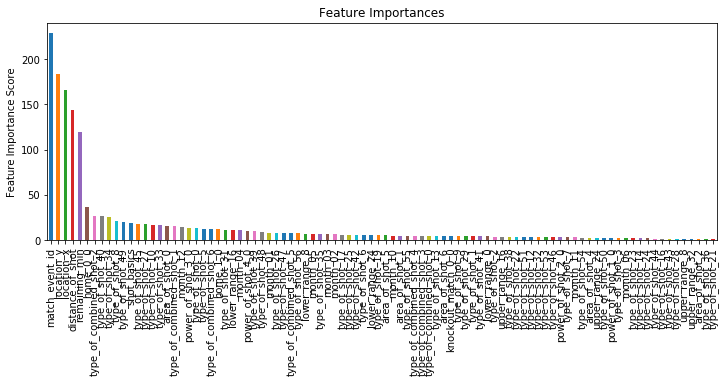

In [51]:
modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [52]:
'''
    TUNING GAMA
'''
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


({'mean_fit_time': array([28.59535127, 27.10575109, 28.10539389, 28.15843081, 25.84967532]),
  'std_fit_time': array([0.63246245, 0.43370455, 1.21017517, 0.69832044, 5.40973399]),
  'mean_score_time': array([0.07324219, 0.07971759, 0.09245124, 0.07482023, 0.06453662]),
  'std_score_time': array([0.00088793, 0.01010845, 0.02712733, 0.0046064 , 0.01475829]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.65980717, 0.65982956, 0.65942715, 0.65925146, 0.65944902]),
  'split1_test_score': array([0.6346175 , 0.63361613, 0.63360961, 0.63426426, 0.63465065]),
  'split2_test_score': array([0.64821221, 0.64870535, 0.64778827, 0.6484782 , 0.64811454]),
  'split3_test_score': array([0.64260806, 0.6426602 , 0.64269971, 0.64438414, 0.642693

[0]	train-auc:0.622829+0.00270568	test-auc:0.617386+0.00755265
[1]	train-auc:0.629057+0.00270725	test-auc:0.624737+0.00894283
[2]	train-auc:0.635852+0.00147364	test-auc:0.629459+0.00744577
[3]	train-auc:0.637665+0.00252508	test-auc:0.631924+0.0053516
[4]	train-auc:0.639651+0.00222801	test-auc:0.633269+0.0054367
[5]	train-auc:0.640223+0.00266197	test-auc:0.633069+0.0065091
[6]	train-auc:0.64212+0.00216209	test-auc:0.633454+0.00628377
[7]	train-auc:0.643737+0.00218152	test-auc:0.634948+0.00530094
[8]	train-auc:0.645215+0.00145239	test-auc:0.636578+0.00527111
[9]	train-auc:0.646569+0.00168637	test-auc:0.637124+0.00601203
[10]	train-auc:0.647192+0.00185877	test-auc:0.637862+0.00648119
[11]	train-auc:0.647874+0.00223238	test-auc:0.638333+0.00693882
[12]	train-auc:0.648801+0.00240806	test-auc:0.638333+0.00674802
[13]	train-auc:0.649286+0.0026249	test-auc:0.638715+0.0068887
[14]	train-auc:0.649668+0.00254514	test-auc:0.639561+0.00637953
[15]	train-auc:0.650486+0.00230864	test-auc:0.64048+0.00

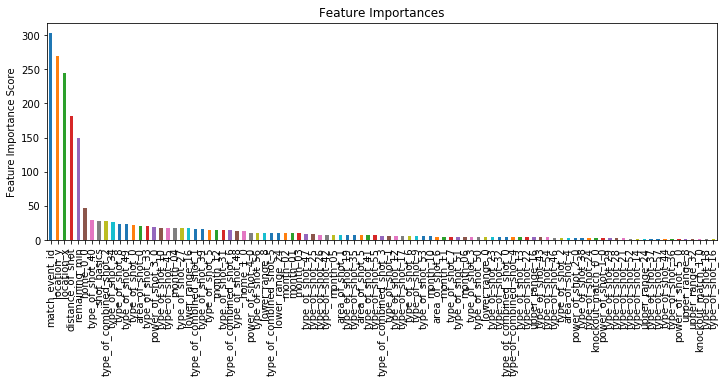

In [53]:
'''
    Recalibrating number of boosting rounds
'''
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)


In [54]:
'''
    Tune subsample and colsample_bytree
'''
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=5, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([32.27995358, 31.19073267, 33.77998252, 34.79750581, 34.89649272,
         36.43877287, 37.07534647, 34.36991301, 38.94485455, 36.89411883,
         36.3123631 , 34.69150147, 41.51507688, 38.94115987, 40.45730557,
         39.67468152]),
  'std_fit_time': array([0.75167704, 0.5142222 , 1.49614475, 0.18517112, 1.6824044 ,
         1.64515668, 2.27980964, 2.20016981, 1.31731705, 0.75771239,
         1.41322044, 0.24808844, 2.68803395, 3.75324348, 2.56385713,
         0.60686192]),
  'mean_score_time': array([0.10282898, 0.08096352, 0.09290309, 0.08796563, 0.1144403 ,
         0.08804622, 0.09191103, 0.08795586, 0.1057528 , 0.09761734,
         0.09176946, 0.10165658, 0.08090901, 0.08313437, 0.0837081 ,
         0.09495559]),
  'std_score_time': array([0.0143426 , 0.00290004, 0.01669729, 0.01417426, 0.01947443,
         0.01179205, 0.01727977, 0.00555111, 0.02482941, 0.01401462,
         0.00748459, 0.01745251, 0.00149711, 0.00352183, 0.00644383,
         0.032993

In [55]:
'''
Here, we found 0.8 as the optimum value for 
both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.
'''
param_test5 = {
 'subsample':[i/100.0 for i in range(80,95,5)],
 'colsample_bytree':[i/100.0 for i in range(55,65,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=235, max_depth=4,
 min_child_weight=5, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.3,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=5,
                                     missing=None, n_estimators=235, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.9, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.55, 0.6],
                         'subsample': [0.8, 0.85, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [56]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([42.06655464, 40.33209181, 38.62588911, 38.63120975, 41.04741826,
         31.55626888]),
  'std_fit_time': array([0.15391672, 2.06294272, 0.75025829, 0.90670699, 1.65227174,
         7.48188928]),
  'mean_score_time': array([0.10419641, 0.10115499, 0.10216374, 0.09911485, 0.09759068,
         0.0796699 ]),
  'std_score_time': array([0.0049673 , 0.00304138, 0.00587686, 0.00242667, 0.0048444 ,
         0.01463124]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.8, 0.85, 0.9, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'colsample_bytree': 0.55, 'subsample': 0.8},
   {'colsample_bytree': 0.55, 'subsample': 0.85},
   {'colsample_bytree': 0.55, 'subsample': 0.9},
   {'col

In [ ]:
'''
Tuning Regularization Parameters
'''
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=235, max_depth=4,
 min_child_weight=5, gamma=0.3, subsample=0.9, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])


In [58]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([43.06538143, 44.82180753, 42.61093917, 43.08210783, 33.00432129]),
  'std_fit_time': array([1.55751638, 1.68370233, 0.16536454, 0.36035826, 8.39660827]),
  'mean_score_time': array([0.12277942, 0.11912599, 0.10132079, 0.10311661, 0.05969729]),
  'std_score_time': array([0.02951566, 0.02566574, 0.00478852, 0.00781183, 0.00973093]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.66165651, 0.6604241 , 0.66018033, 0.6624426 , 0.63860837]),
  'split1_test_score': array([0.63316412, 0.63399904, 0.6324613 , 0.63236303, 0.61511906]),
  'split2_test_score': array([0.65171605, 0.65185731, 0.65220351, 0.64985747, 0.63277697]),
  'split3_test_score': array([0.642212  , 0.64295069, 0.6444

In [59]:
param_test7 = {
 'reg_alpha':[0, 0.05, 0.1, 0.15, 0.2 ]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=255, max_depth=4,
 min_child_weight=5, gamma=0.3, subsample=0.9, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([44.66606297, 47.38557401, 51.35614891, 47.84707351, 47.49578662]),
  'std_fit_time': array([ 0.8461727 ,  1.4534837 ,  1.59530085,  2.38956377, 12.72959873]),
  'mean_score_time': array([0.11298385, 0.1930119 , 0.11981649, 0.18753104, 0.10644774]),
  'std_score_time': array([0.01263346, 0.06420252, 0.01820465, 0.07492749, 0.03092362]),
  'param_reg_alpha': masked_array(data=[0, 0.05, 0.1, 0.15, 0.2],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.05},
   {'reg_alpha': 0.1},
   {'reg_alpha': 0.15},
   {'reg_alpha': 0.2}],
  'split0_test_score': array([0.66077437, 0.65788474, 0.65943876, 0.66155511, 0.66156316]),
  'split1_test_score': array([0.631949  , 0.63047579, 0.63148648, 0.63106906, 0.63140593]),
  'split2_test_score': array([0.65198102, 0.65171554, 0.65214458, 0.65163457, 0.65318656]),
  'split3_test_score': array([0.64224685, 0.64577036, 0.6

[0]	train-auc:0.610009+0.00210375	test-auc:0.602984+0.00822954
[1]	train-auc:0.625554+0.00329553	test-auc:0.620891+0.00871745
[2]	train-auc:0.630046+0.00380907	test-auc:0.625238+0.00725226
[3]	train-auc:0.632673+0.00399248	test-auc:0.626927+0.00603667
[4]	train-auc:0.634393+0.00249034	test-auc:0.628744+0.00648944
[5]	train-auc:0.634895+0.00203821	test-auc:0.629001+0.00689931
[6]	train-auc:0.636278+0.00194974	test-auc:0.629811+0.00747301
[7]	train-auc:0.636878+0.00246493	test-auc:0.630532+0.00725714
[8]	train-auc:0.637041+0.00204252	test-auc:0.630473+0.00785485
[9]	train-auc:0.637775+0.00207152	test-auc:0.630771+0.00761803
[10]	train-auc:0.638249+0.00168954	test-auc:0.631053+0.00737471
[11]	train-auc:0.638421+0.00172256	test-auc:0.631578+0.00702758
[12]	train-auc:0.638642+0.00167632	test-auc:0.631431+0.0071972
[13]	train-auc:0.63928+0.00189152	test-auc:0.631954+0.00722129
[14]	train-auc:0.639659+0.00187293	test-auc:0.632185+0.00713552
[15]	train-auc:0.639918+0.00181981	test-auc:0.632327

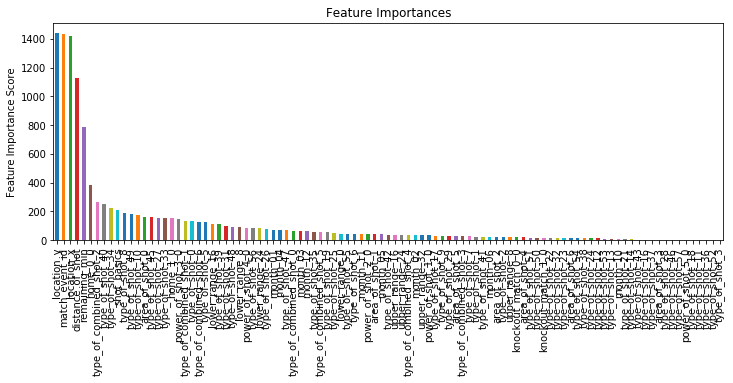

In [60]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=5,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.55,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

In [ ]:
'''
({'mean_fit_time': array([25.47543125, 29.29744964, 37.45478344, 51.23701358, 45.63270326,
         61.34791794, 63.19848642, 56.18198481, 58.7547133 , 59.78487515,
         60.19948406, 55.76035213]),
  'std_fit_time': array([ 0.53580202,  6.02017352,  0.63569917,  1.8163702 , 12.13455724,
          9.0683577 ,  2.39844681,  2.17152607,  3.73682286,  2.62456035,
          1.12735729,  4.10586478]),
  'mean_score_time': array([0.06946297, 0.07501221, 0.17372174, 0.20709124, 0.25987864,
         0.15443721, 0.26897616, 0.21223593, 0.18476658, 0.1734283 ,
         0.20747576, 0.14157748]),
  'std_score_time': array([0.0065865 , 0.00747546, 0.07382257, 0.08597596, 0.1022942 ,
         0.03309303, 0.11645871, 0.06307146, 0.0392818 , 0.02075738,
         0.06637969, 0.03079519]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 3, 'min_child_weight': 1},
   {'max_depth': 3, 'min_child_weight': 3},
   {'max_depth': 3, 'min_child_weight': 5},
   {'max_depth': 5, 'min_child_weight': 1},
   {'max_depth': 5, 'min_child_weight': 3},
   {'max_depth': 5, 'min_child_weight': 5},
   {'max_depth': 7, 'min_child_weight': 1},
   {'max_depth': 7, 'min_child_weight': 3},
   {'max_depth': 7, 'min_child_weight': 5},
   {'max_depth': 9, 'min_child_weight': 1},
   {'max_depth': 9, 'min_child_weight': 3},
   {'max_depth': 9, 'min_child_weight': 5}],
  'split0_test_score': array([0.65859375, 0.65832107, 0.65746317, 0.65620218, 0.65849361,
         0.65713478, 0.65729401, 0.65315332, 0.65398561, 0.65681114,
         0.65669489, 0.65556753]),
  'split1_test_score': array([0.63414827, 0.6327172 , 0.63272449, 0.63118234, 0.62533873,
         0.63347123, 0.6273156 , 0.62885936, 0.62369662, 0.62028901,
         0.62614652, 0.62337815]),
  'split2_test_score': array([0.64755535, 0.64630454, 0.64629029, 0.6459675 , 0.65117671,
         0.65230492, 0.64069436, 0.64240812, 0.64426925, 0.62937556,
         0.64228077, 0.63702196]),
  'split3_test_score': array([0.64026719, 0.63931568, 0.64157998, 0.63952163, 0.63981467,
         0.6418954 , 0.63134946, 0.63694565, 0.63485957, 0.622734  ,
         0.62925185, 0.63085692]),
  'split4_test_score': array([0.65036493, 0.64987004, 0.65032812, 0.64807278, 0.64862052,
         0.64793757, 0.64963812, 0.6510551 , 0.64363405, 0.64543547,
         0.6430769 , 0.64304865]),
  'mean_test_score': array([0.6461859 , 0.6453057 , 0.64567721, 0.64418929, 0.64468885,
         0.64654878, 0.64125831, 0.64248431, 0.64008902, 0.63492904,
         0.63949019, 0.63797464]),
  'std_test_score': array([0.00840512, 0.00878159, 0.00831235, 0.00840858, 0.01136931,
         0.0082438 , 0.01113793, 0.00898452, 0.01019034, 0.01402214,
         0.01095016, 0.01095338]),
  'rank_test_score': array([ 2,  4,  3,  6,  5,  1,  8,  7,  9, 12, 10, 11], dtype=int32)},
 {'max_depth': 5, 'min_child_weight': 5},
 0.6465487780417231)
 
 
 
 
 
 
 
 ({'mean_fit_time': array([28.97310758, 29.19032226, 26.44795671, 32.02436671, 30.11715417,
         31.42415733, 34.43228965, 36.22571115, 30.53552098]),
  'std_fit_time': array([1.03048461, 2.03615444, 0.25609932, 0.95212453, 0.30985652,
         1.70290915, 1.46366673, 1.47890386, 6.02755877]),
  'mean_score_time': array([0.08572855, 0.08006516, 0.07456479, 0.09054503, 0.08925452,
         0.08765597, 0.09144964, 0.11746426, 0.07450438]),
  'std_score_time': array([0.01973125, 0.00963097, 0.00436722, 0.00995394, 0.0104075 ,
         0.0154485 , 0.00340498, 0.05036184, 0.01114788]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 4},
   {'max_depth': 4, 'min_child_weight': 5},
   {'max_depth': 4, 'min_child_weight': 6},
   {'max_depth': 5, 'min_child_weight': 4},
   {'max_depth': 5, 'min_child_weight': 5},
   {'max_depth': 5, 'min_child_weight': 6},
   {'max_depth': 6, 'min_child_weight': 4},
   {'max_depth': 6, 'min_child_weight': 5},
   {'max_depth': 6, 'min_child_weight': 6}],
  'split0_test_score': array([0.65867667, 0.65922908, 0.65980717, 0.65839653, 0.65713478,
         0.65443864, 0.65482757, 0.65610399, 0.65871678]),
  'split1_test_score': array([0.6346186 , 0.63633253, 0.6346175 , 0.62868995, 0.63347123,
         0.63285973, 0.62797653, 0.62974795, 0.62981155]),
  'split2_test_score': array([0.65055893, 0.65201824, 0.64821221, 0.65244702, 0.65230492,
         0.6481181 , 0.64482479, 0.64633989, 0.64538304]),
  'split3_test_score': array([0.64389067, 0.64088496, 0.64260806, 0.64157634, 0.6418954 ,
         0.6419311 , 0.63852366, 0.63771689, 0.63855113]),
  'split4_test_score': array([0.65062086, 0.65179845, 0.64980184, 0.64903796, 0.64793757,
         0.64896959, 0.64640811, 0.64936184, 0.64703949]),
  'mean_test_score': array([0.64767315, 0.64805265, 0.64700936, 0.64602956, 0.64654878,
         0.64526343, 0.64251213, 0.64385411, 0.6439004 ]),
  'std_test_score': array([0.00803521, 0.00828742, 0.00831816, 0.01023396, 0.0082438 ,
         0.00736241, 0.00893743, 0.00920025, 0.00957797]),
  'rank_test_score': array([2, 1, 3, 5, 4, 6, 9, 8, 7], dtype=int32)},
 {'max_depth': 4, 'min_child_weight': 5},
 0.6480526533601416)
 
 
 
 
 GAMMA
 
 ({'mean_fit_time': array([28.59535127, 27.10575109, 28.10539389, 28.15843081, 25.84967532]),
  'std_fit_time': array([0.63246245, 0.43370455, 1.21017517, 0.69832044, 5.40973399]),
  'mean_score_time': array([0.07324219, 0.07971759, 0.09245124, 0.07482023, 0.06453662]),
  'std_score_time': array([0.00088793, 0.01010845, 0.02712733, 0.0046064 , 0.01475829]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.65980717, 0.65982956, 0.65942715, 0.65925146, 0.65944902]),
  'split1_test_score': array([0.6346175 , 0.63361613, 0.63360961, 0.63426426, 0.63465065]),
  'split2_test_score': array([0.64821221, 0.64870535, 0.64778827, 0.6484782 , 0.64811454]),
  'split3_test_score': array([0.64260806, 0.6426602 , 0.64269971, 0.64438414, 0.64269301]),
  'split4_test_score': array([0.64980184, 0.64978267, 0.64997557, 0.64997608, 0.65126581]),
  'mean_test_score': array([0.64700936, 0.64691878, 0.64670006, 0.64727083, 0.64723461]),
  'std_test_score': array([0.00831816, 0.00863919, 0.00850005, 0.00812177, 0.00830902]),
  'rank_test_score': array([3, 4, 5, 1, 2], dtype=int32)},
 {'gamma': 0.3},
 0.6472708288736031)
 
 
 
 
 
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0.3,
 
 [235]	train-auc:0.733589+0.00160811	test-auc:0.650496+0.00236112

Model Report
Accuracy : 0.6552
AUC Score (Train): 0.715594


-------------------------------

Tune subsample and colsample_bytree - 

{'colsample_bytree': 0.6, 'subsample': 0.9},
 0.6473191242898737)
 
 
 
  {'colsample_bytree': 0.55, 'subsample': 0.9},
 0.6474671923222781)
 
 
 
 
 -----------------------------------
 Tuning Regularization parameter
 
{'reg_alpha': 0.1},
 0.6482818380216636)
 
 
 {'reg_alpha': 0.1},
 0.6479204871740654)
 

'''

In [ ]:
X = submission.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].values
y = submission[['is_goal']].values

# ''' Feature Scaling '''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =sc_X.fit_transform(X)

probs = xboost_classifier.predict_proba(X)

In [ ]:
solution = pd.DataFrame(columns=['shot_id_number', 'is_goal'])

solution['shot_id_number'] = submission['shot_id_number']
solution['is_goal'] = probs

In [ ]:
solution.to_csv("bhavi_chawla_280998_code_2.csv",index=False)

In [ ]:
!jupyter nbconvert --to script main.ipynb